## Install

In [ ]:
# install
!pip install federpy

# import
from federpy.federpy import FederPy

### Data Preparation

In [80]:
# index file built by hnswlib or faiss.
hnswSource = 'hnswlib'
hnswIndexFile = 'https://assets.zilliz.com/hnswlib_hnsw_voc_17k_1f1dfd63a9.index'

ivfflatSource = 'faiss'
ivfflatIndexFile = 'https://assets.zilliz.com/faiss_ivf_flat_voc_17k_ab112eec72.index'

In [81]:
import pandas as pd

# this csv includes 17,000+ items，each only includes its filename.
namesFile = "https://assets.zilliz.com/voc_names_4cee9440b1.csv"

namesCsv = pd.read_csv(namesFile)
imageUrls = ["https://assets.zilliz.com/voc2012/JPEGImages/%s" % row['name'] for index, row in namesCsv.iterrows()]

## Vis for IVF_Flat (faiss)

In [82]:
ivfflatViewParams = {
    "width": 800,
    "height": 500,
    "mediaType": "image",
    "mediaUrls": imageUrls,
    "projectMethod": "umap",
}
federPy_ivfflat = FederPy(ivfflatIndexFile, ivfflatSource, **ivfflatViewParams)

### Overview

In [ ]:
federPy_ivfflat.overview()

### Search View

In [ ]:
federPy_ivfflat.setSearchParams({"k": 9, "nprobe": 8}).searchRandTestVec()

## Vis for HNSW (hnswlib)

In [85]:
# init federpy
hnswViewParams = {
    "width": 800,
    "height": 500,
    "mediaType": "image",
    "mediaUrls": imageUrls
}
federPy_hnsw = FederPy(hnswIndexFile, hnswSource, **hnswViewParams)

### Overview

In [ ]:
federPy_hnsw.overview()

### Search View

In [ ]:
federPy_hnsw.setSearchParams({"k": 6, "ef": 8}).searchRandTestVec()

## Code

### IVF, HNSW class

In [36]:

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


class IVF:

    def _compute_distance(self, data, q):
        """Compute the appropriate distance based on the distance type."""
        if self.distance_type == 'l2':
            return np.linalg.norm(data - q, axis=1)
        elif self.distance_type == 'cosine':
            return 1 - np.dot(data, q.T) / (np.linalg.norm(data, axis=1) * np.linalg.norm(q))


    def __init__(self, distance_type, n_clusters):

        self.n_clusters = n_clusters
        self.distance_type = distance_type
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.inverted_index = {i: [] for i in range(n_clusters)}
        self.data = None
        self.visited_count = 0


    def fit(self, X):

        if self.distance_type == 'cosine':
            X = X / np.linalg.norm(X, axis=1, keepdims=True)

        self.kmeans.fit(X)
        labels = self.kmeans.labels_

        for idx, label in enumerate(labels):
            self.inverted_index[label].append(idx)

        self.data = X



    def search(self, q, k, n_probes=1):

        self.visited_count = 0

        assert n_probes <= self.n_clusters

        if self.distance_type == "cosine":
            q = q / np.linalg.norm(q)

        cluster_distances = self._compute_distance(self.kmeans.cluster_centers_, q).flatten()
        probe_clusters = np.argpartition(cluster_distances, n_probes)[:n_probes]

        candidates = np.concatenate([self.inverted_index[cl] for cl in probe_clusters])

        self.visited_count += len(candidates)

        if len(candidates) <= k:
            return candidates

        dists = self._compute_distance(self.data[candidates], q).flatten()
        top_idx = np.argpartition(dists, k)[:k]

        top_k = candidates[top_idx]
        top_dist = dists[top_idx]

        return [(k, dist) for k, dist in zip(top_k, top_dist)]



In [25]:
# https://github.com/RyanLiGod/hnsw-python/blob/master/hnsw.py

from heapq import heapify, heappop, heappush, heapreplace, nlargest
from math import log2
from operator import itemgetter
from random import random
import numpy as np

class HNSW:
    # self._graphs[level][i] contains a {j: dist} dictionary,
    # where j is a neighbor of i and dist is distance

    def l2_distance(self, a, b):
        return np.linalg.norm(a - b)

    def cosine_distance(self, a, b):
        try:
            return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        except ValueError:
            print(a)
            print(b)

    def vectorized_distance_(self, x, ys):
        return [self.distance_func(x, y) for y in ys]

    def __init__(self, distance_type, M=5, efConstruction=200, Mmax=None):
        if distance_type == "l2":
            distance_func = self.l2_distance
        elif distance_type == "cosine":
            distance_func = self.cosine_distance
        else:
            raise TypeError('Please check your distance type!')
        self.distance_func = distance_func
        self.vectorized_distance = self.vectorized_distance_
        self._M = M
        self._efConstruction = efConstruction
        self._Mmax = 2 * M if Mmax is None else Mmax
        self._level_mult = 1 / log2(M)
        self._graphs = []
        self._enter_point = None
        self.data = []
        self.visited_count = 0

    ### Algorithm 1: INSERT
    def insert(self, q, efConstruction=None):

        if efConstruction is None:
            efConstruction = self._efConstruction

        distance = self.distance_func
        data = self.data
        graphs = self._graphs
        ep = self._enter_point
        M = self._M

        # line 4: determine level for the new element q
        l = int(-log2(random()) * self._level_mult) + 1
        idx = len(data)
        data.append(q)

        if ep is not None:
            neg_dist = -distance(q, data[ep])
            # distance(q, data[ep])|

            # line 5-7: find the closest neighbor for levels above the insertion level
            for lc in reversed(graphs[l:]):
                neg_dist, ep = self._search_layer(q, [(neg_dist, ep)], lc, 1)[0]

            # line 8-17: insert q at the relevant levels; W is a candidate list
            layer0 = graphs[0]
            for lc in reversed(graphs[:l]):
                M_layer = M if lc is not layer0 else self._Mmax

                # line 9: update W with the closest nodes found in the graph
                W = self._search_layer(q, [(neg_dist, ep)], lc, efConstruction)

                # line 10: insert the best neighbors for q at this layer
                lc[idx] = layer_idx = {}
                self._select(layer_idx, W, M_layer, lc, heap=True)

                # line 11-13: insert bidirectional links to the new node
                for j, dist in layer_idx.items():
                    self._select(lc[j], (idx, dist), M_layer, lc)

        # line 18: create empty graphs for all new levels
        for _ in range(len(graphs), l):
            graphs.append({idx: {}})
            self._enter_point = idx


    ### Algorithm 5: K-NN-SEARCH
    def search(self, q, K=5, efSearch=20):
        """Find the K points closest to q."""

        distance = self.distance_func
        graphs = self._graphs
        ep = self._enter_point
        self.visited_count = 0

        if ep is None:
            raise ValueError("Empty graph")

        neg_dist = -distance(q, self.data[ep])

        # line 1-5: search from top layers down to the second level
        for lc in reversed(graphs[1:]):
            neg_dist, ep = self._search_layer(q, [(neg_dist, ep)], lc, 1)[0]

        # line 6: search with efSearch neighbors at the bottom level
        W = self._search_layer(q, [(neg_dist, ep)], graphs[0], efSearch)

        if K is not None:
            W = nlargest(K, W)
        else:
            W.sort(reverse=True)

        return [(idx, -md) for md, idx in W]


    ### Algorithm 2: SEARCH-LAYER
    def _search_layer(self, q, W, lc, ef):

        vectorized_distance = self.vectorized_distance
        data = self.data

        # Step 1: Initialize candidate list and visited set
        C = [(-neg_dist, idx) for neg_dist, idx in W]
        heapify(C)
        heapify(W)
        visited = set(idx for _, idx in W)

        # Step 4-17: Explore neighbors until candidate list is exhausted
        while C:
            dist, c = heappop(C)
            furthest = -W[0][0]
            if dist > furthest:
                break
            neighbors = [e for e in lc[c] if e not in visited]
            visited.update(neighbors)
            dists = vectorized_distance(q, [data[e] for e in neighbors])
            for e, dist in zip(neighbors, dists):
                self.visited_count += 1
                neg_dist = -dist
                if len(W) < ef:
                    heappush(C, (dist, e))
                    heappush(W, (neg_dist, e))
                    furthest = -W[0][0]
                elif dist < furthest:
                    heappush(C, (dist, e))
                    heapreplace(W, (neg_dist, e))
                    furthest = -W[0][0]

        return W

    ### Algorithm 3: SELECT-NEIGHBORS-SIMPLE
    def _select(self, R, C, M, lc, heap=False):

        if not heap:
            idx, dist = C
            if len(R) < M:
                R[idx] = dist
            else:
                max_idx, max_dist = max(R.items(), key=itemgetter(1))
                if dist < max_dist:
                    del R[max_idx]
                    R[idx] = dist
            return

        else:
            C = nlargest(M, C)
            R.update({idx: -neg_dist for neg_dist, idx in C})


### Data Preparation

In [ ]:
import pandas as pd

data_raw = pd.read_parquet('openai_embedding_raw.parquet')
data_raw.head()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import time

f = h5py.File('openai_embedding_output.hdf5','r')
distances = f['distances']
neighbors = f['neighbors']
test = f['test']
train = f['train']

In [ ]:
distances

In [ ]:
distances[0]

In [ ]:
neighbors

In [ ]:
neighbors[0]

In [ ]:
train

In [ ]:
test

### IVF code

In [37]:
ivf = IVF("cosine", n_clusters = 100)

ivf.fit(train)

In [38]:
## cluster 확인
# ivf.inverted_index

In [ ]:
## cluster별 데이터 수
for i in range(10):
    print(f"cluster {i} : {len(ivf.inverted_index[i])}")

In [ ]:
## centroid 확인
ivf.kmeans.cluster_centers_

In [ ]:
## search
ivf.search(test[0], k = 5, n_probes = 3)

In [ ]:
## 방문한 벡터 수
ivf.visited_count

In [ ]:
## true-NN 확인
[(n, d) for d, n in zip(distances[0][:5], neighbors[0][:5])]

### IVF 성능평가

In [108]:
## index build time
n_clusters = [50, 100, 150]
times = []
for n_cluster in n_clusters:
    ivf = IVF("cosine", n_clusters = n_cluster)
    start = time.time()
    ivf.fit(train)
    times.append(time.time() - start)

for n_cluster, time_ in zip(n_clusters, times):
    print(f"n_cluster : {n_cluster}, build time : {time_}")


n_cluster : 50, build time : 7.234094619750977
n_cluster : 100, build time : 12.92861819267273
n_cluster : 150, build time : 19.378098726272583


In [ ]:
## n_cluster = sqrt(len(data))를 권장

ivf = IVF("cosine", n_clusters = 100)
ivf.fit(train)

In [ ]:
## search speed and accuracy with different n_probe
n_probes = [3, 7, 10, 15]
qps_ivf = []
accuracies_ivf = []
visited_ivf = []

for n_probe in n_probes:

    query_acc = []
    query_per_second = []
    query_visit = []

    for i in range(len(test)):
        start = time.time()
        search_result = ivf.search(test[i], 5, n_probe)
        query_per_second.append(time.time() - start)

        acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
        query_acc.append(acc)

        query_visit.append(ivf.visited_count)

    accuracies_ivf.append(np.mean(query_acc))
    qps_ivf.append(1 / np.mean(query_per_second))
    visited_ivf.append(np.mean(query_visit))

for n_probe, acc, qp, v in zip(n_probes, accuracies_ivf, qps_ivf, visited_ivf):
    print(f"n_probe : {n_probe}, accuracy : {acc}, qps : {qp}, visited : {v}")

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=accuracies_ivf, y=qps_ivf)
sns.scatterplot(x=accuracies_ivf, y=qps_ivf, hue=n_probes, s=100, legend="full", palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Query Per Second (QPS)")
plt.legend(title="n_probe")
plt.title("Accuracy vs Query Per Second")

plt.subplot(1, 2, 2)
sns.lineplot(x=accuracies_ivf, y=visited_ivf)
sns.scatterplot(x=accuracies_ivf, y=visited_ivf, hue=n_probes, s=100, palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Visited Nodes")
plt.legend(title="n_probe")
plt.title("Accuracy vs Visited Nodes")

plt.tight_layout()
plt.show()

### HNSW code

In [26]:
hnsw = HNSW("cosine", M = 16, efConstruction=64)

for i in range(len(train)):
    hnsw.insert(train[i])

In [27]:
## hnsw index 확인
# hnsw._graphs

In [ ]:
## layer별 노드 수
for i in range(len(hnsw._graphs)):
    print(f"layer {i} : {len(hnsw._graphs[i])}")

In [ ]:
## search

hnsw.search(test[0], 5)

In [ ]:
## true-NN 확인
[(n, d) for d, n in zip(distances[0][:5], neighbors[0][:5])]

In [ ]:
## 평균 방문 노드 수 확인
visit = []
for i in range(len(test)):
    hnsw.search(test[i], 5, 20)
    visit.append(hnsw.visited_count)

print(np.mean(visit))

In [ ]:
visit_k = []

for ef in [20, 50, 100]:
    visit = []
    for i in range(len(test)):
        hnsw.search(test[i], 5, ef)
        visit.append(hnsw.visited_count)

    visit_k.append(np.mean(visit))

visit_k

### HNSW 성능평가

In [127]:
build_time_df = pd.DataFrame(columns=["M", "efConstruction", "build time"])

# Parameters
M = [5, 10, 15]
efConstruction = [32, 48, 64]

for m in M:
    for ef in efConstruction:
        hnsw = HNSW("cosine", M=m, efConstruction=ef)
        start = time.time()
        for i in range(len(train)):
            hnsw.insert(train[i])
        build_time = time.time() - start

        # Use pd.concat to add a row
        build_time_df = pd.concat(
            [build_time_df, pd.DataFrame({"M": [m], "efConstruction": [ef], "build time": [build_time]})],
            ignore_index=True
        )

<ipython-input-127-26ca1310b0c9>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  build_time_df = pd.concat(


In [128]:
build_time_df

,M,efConstruction,build time
0,5,32,45.532506
1,5,48,56.865551
2,5,64,57.885981
3,10,32,55.697878
4,10,48,73.326232
5,10,64,88.719386
6,15,32,71.125389
7,15,48,92.047587
8,15,64,112.499682


<Axes: xlabel='M', ylabel='build time'>

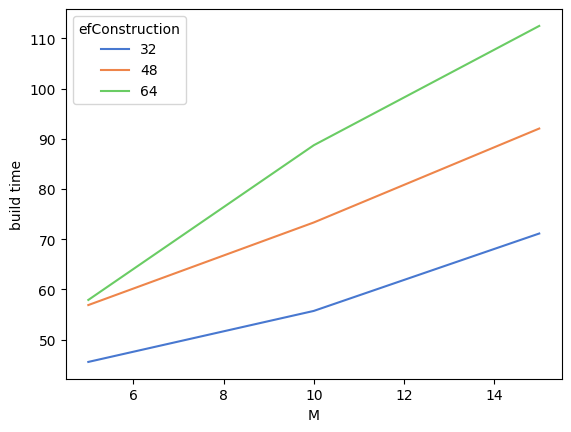

In [129]:
sns.lineplot(x = 'M', y = 'build time', data = build_time_df, hue = 'efConstruction', palette = "muted")

In [ ]:
efs = [10, 20, 30, 50, 100]
accuracies_hnsw = []
qps_hnsw = []
visited_hnsw = []

for ef in efs:

    query_acc = []
    query_per_second = []
    query_visit = []

    for i in range(len(test)):
        start = time.time()
        search_result = hnsw.search(test[i], 5, ef)
        query_per_second.append(time.time() - start)

        acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
        query_acc.append(acc)

        query_visit.append(hnsw.visited_count)

    qps_hnsw.append(1 / np.mean(query_per_second))
    accuracies_hnsw.append(np.mean(query_acc))
    visited_hnsw.append(np.mean(query_visit))


for ef, acc, qp, v in zip(efs, accuracies_hnsw, qps_hnsw, visited_hnsw):
    print(f"ef : {ef}, accuracy : {acc}, qps : {qp}, visited : {v}")


In [ ]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=accuracies_hnsw, y=qps_hnsw)
sns.scatterplot(x=accuracies_hnsw, y=qps_hnsw, hue=efs, s=100, legend="full", palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Query Per Second (QPS)")
plt.legend(title="n_probe")


plt.subplot(1, 2, 2)
sns.lineplot(x=accuracies_hnsw, y=visited_hnsw)
sns.scatterplot(x=accuracies_hnsw, y=visited_hnsw, hue=efs, s=100, palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Visited Nodes")
plt.legend(title="n_probe")
plt.title("Accuracy vs Visited Nodes")

plt.tight_layout()
plt.show()

### IVF vs HNSW

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=accuracies_ivf, y=qps_ivf, label = "IVF")
sns.lineplot(x=accuracies_hnsw, y=qps_hnsw, label = "HNSW")
plt.title("Accuracy vs Query Per Second")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Query Per Second (QPS)")
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x=accuracies_ivf, y=visited_ivf, label = "IVF")
sns.lineplot(x=accuracies_hnsw, y=visited_hnsw, label = "HNSW")
plt.title("Accuracy vs Visited Nodes")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Query Per Second (QPS)")
plt.legend()

plt.show()